In [25]:
import numpy as np
import matplotlib.pyplot as plt



from Project.BallOnIncline.BallOnIncline_data import *
from pathlib import Path
from iminuit import Minuit
from iminuit import cost
from scipy import stats


In [26]:
#Measurements in mm and degree
# Setup_Base = 90.05
# Setup_Base_Sigma = 1e-3
#
# Setup_Height = 22.17
# Setup_Height_Sigma = 1e-3
#
# Ball_Diameter = {'big': 15.00, 'medium': 12.67, 'little': 10.00}
# Ball_Diameter_Sigma ={'big': 1e-3, 'medium': 1e-3, 'little': 1e-3}
#
# Rail_Spacing = 6.06
# Rail_Spacing_Sigma = 1e-3
#
# Setup_Angle = np.array([13.79,14.09])
# Setup_Angle_Sigma = 1e-2
#
# Gate_Spacing = [16.35, 34.05, 52.18, 71.21, 88.75] # entry 1 is the higest placed gate
# Gate_Spacing_Sigma = [1e-3, 1e-3, 1e-3, 1e-3, 1e-3] # entry 1 is the higest placed gate

# finding Mean gate spacing

In [27]:
def WeigthedMean(x, sigmax):
    top = 0
    btm = 0
    for xi, si in zip(x,sigmax):
        top += xi/si
        btm += 1/si
    WeightMean = top/btm
    return WeightMean, 1/btm

GateNamex = [gate1, gate2, gate3, gate4, gate5]
GateNamesig = [sig_gate1, sig_gate2, sig_gate3, sig_gate4, sig_gate5]


GateXMeans = []
GateXSigmas = []
for xi,si in zip(GateNamex, GateNamesig):
    WmeanX, std = WeigthedMean(xi, si)
    GateXMeans.append(WmeanX)
    GateXSigmas.append(std)


In [28]:
def read_csv(filename, trim, trimend=1):
    """Read CSV from Waveforms"""
    dat = np.genfromtxt(filename, delimiter=',', skip_header=13, names=True)
    trimdat = dat[trim:-trimend]
    time = trimdat['Time_s']
    voltage = trimdat['Channel_1_V']
    return time, voltage

Text(0, 0.5, 'Voltage (V)')

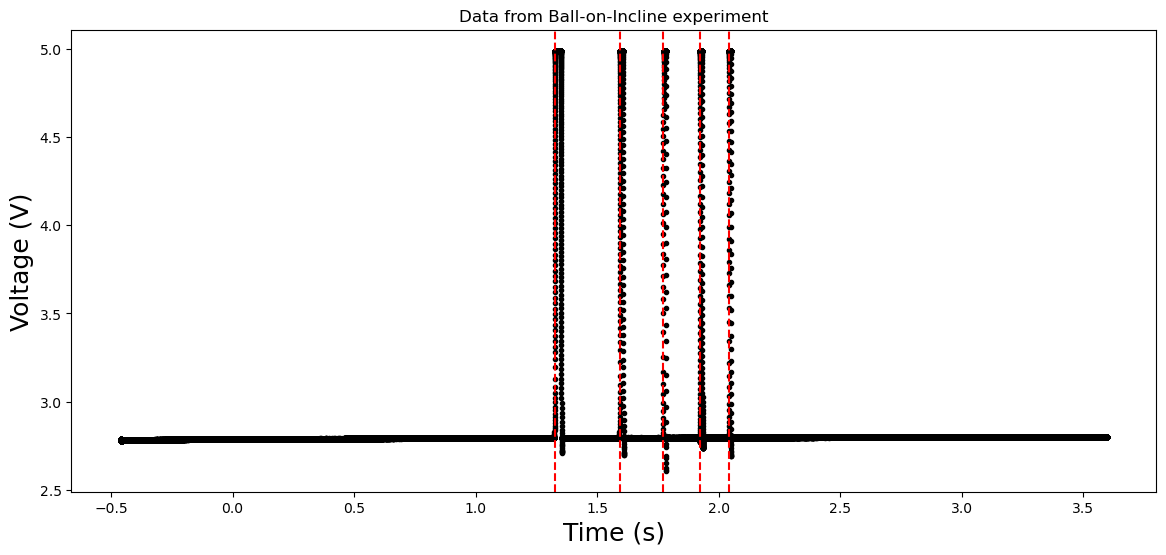

In [29]:
def find_midpoints(time, voltage):
    """Find timing of ball crossings"""
    threshold = np.mean(voltage)+ np.std(voltage)
    Transient_Mask = (voltage[:-1] < threshold) & (voltage[1:] >= threshold)
    Transient_Times = np.array(time[1:])[Transient_Mask]
    return Transient_Times, np.mean(np.diff(time))

filename = 'Waveforms_data/Big_1.csv'
# Read the data and plot it (possibly with passing times in):

trim = 2000
trimend = 2000
time, voltage = read_csv(filename, trim,trimend)

timepass, time_Sigma = find_midpoints(time, voltage)

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(time, voltage, 'k.', label='Measurements')
#adding a vertical line at each time the ball passes
for t in timepass:
    ax.axvline(t, color='r', linestyle='--', label='Ball pass' if t == timepass[0] else "")
ax.set_title("Data from Ball-on-Incline experiment")
ax.set_xlabel("Time (s)", fontsize=18)
ax.set_ylabel("Voltage (V)", fontsize=18)



In [30]:
#getting the five passthrough times for each experiment
TimeArray = []
TimeSigmaArray = []
for Fi in filenames:
    Base = 'Waveforms_data'
    trim = 2000
    trimend = 2000
    Time, voltage = read_csv(Path(Base) / Fi, trim,trimend)

    if Time[0] != 0:
        Time = np.array(Time) - Time[0]
    Timepass, TimeSigma = find_midpoints(Time, voltage)

    TimeArray.append(Timepass)
    TimeSigmaArray.append(TimeSigma)

In [31]:
def Parapolic_fit(x, a ,v0, s0):
    y = 1/2*a *x**2 +v0*x+ s0
    return y

In [103]:
ParabolicFitObj = cost.LeastSquares(x = TimeArray[4], y =GateXMeans, yerror=GateXSigmas, model= Parapolic_fit)
fit = Minuit(ParabolicFitObj, a=0.6, s0 = 2, v0 = 2)
fit.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 91.66 (χ²/ndof = 45.8)     │              Nfcn = 76               │
│ EDM = 7.94e-10 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │  1.5410   │  0.0013   │            │            │         │         │       │
│ 1 │ v0   │  -3.566   │   0.004   │            │            │         │         │       │
│ 2 │ s0   │   4.222   │   0.006   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────┐
│    │         a        v0        s0 │
├────┼───────────────────────────────┤
│  a │  1.73e-06   -5.1e-6    7.4e-6 │
│ v0 │   -5.1e-6  1.49e-05 -0.022e-3 │
│ s0 │    7.4e-6 -0.022e-3  3.17e-05 │
└────┴───────────────────────────────┘

In [33]:
AccelerationValueArray = []
AccelerationSigmaArray = []

for TArri in TimeArray:
    ParabolicFitObj = cost.LeastSquares(x = TArri, y = GateXMeans, yerror = GateXSigmas, model = Parapolic_fit)
    fiti = Minuit(ParabolicFitObj, a=0.5,v0 = 2, s0 = 2)
    fiti.migrad()
    AccelerationValueArray.append(fiti.values[0])
    AccelerationSigmaArray.append(fiti.errors[0])


AccelerationValueArray = np.array(AccelerationValueArray)
AccelerationSigmaArray = np.array(AccelerationSigmaArray)
AccelerationsArray = np.column_stack((AccelerationValueArray, AccelerationSigmaArray))

ForwardAccelerationValues = AccelerationsArray[::2, :]
ReverseAccelerationValues = AccelerationsArray[1::2,:]

ForwardAccelerationValuesBig = ForwardAccelerationValues[:4]
ReverseAccelerationValuesBig = ReverseAccelerationValues[:4]

ForwardAccelerationValuesSmall = ForwardAccelerationValues[4:8]
ReverseAccelerationValuesSmall = ReverseAccelerationValues[4:8]

ForwardAccelerationValuesMedium = ForwardAccelerationValues[8:12]
ReverseAccelerationValuesMedium = ReverseAccelerationValues[8:12]



In [34]:
ForwardAccelerationBig = WeigthedMean(ForwardAccelerationValuesBig[:,0],ForwardAccelerationValuesBig[:,1] )
ForwardAccelerationMedium = WeigthedMean(ForwardAccelerationValuesMedium[:,0],ForwardAccelerationValuesMedium[:,1] )
ForwardAccelerationSmall = WeigthedMean(ForwardAccelerationValuesSmall[:,0],ForwardAccelerationValuesSmall[:,1] )

print(f'Forward Acceleration big {ForwardAccelerationBig[0]}+- {ForwardAccelerationBig[1]}')
print(f'Forward Acceleration Medium {ForwardAccelerationMedium[0]}+- {ForwardAccelerationMedium[1]}')
print(f'Forward Acceleration Small {ForwardAccelerationSmall[0]}+- {ForwardAccelerationSmall[1]}')

Forward Acceleration big 1.5418933197438094+- 0.00032870869744863653
Forward Acceleration Medium 1.4878534808541106+- 0.00031907642486975115
Forward Acceleration Small 1.3833624206305575+- 0.00029622946208966526


In [104]:
ReverseAccelerationBig = WeigthedMean(ReverseAccelerationValuesBig[:,0],ReverseAccelerationValuesBig[:,1] )
ReverseAccelerationMedium = WeigthedMean(ReverseAccelerationValuesMedium[:,0],ReverseAccelerationValuesMedium[:,1] )
ReverseAccelerationSmall = WeigthedMean(ReverseAccelerationValuesSmall[:,0],ReverseAccelerationValuesSmall[:,1] )

print(f'Forward Acceleration big    {ReverseAccelerationBig[0]}+- {ReverseAccelerationBig[1]}')
print(f'Forward Acceleration Medium {ReverseAccelerationMedium[0]}+- {ReverseAccelerationMedium[1]}')
print(f'Forward Acceleration Small  {ReverseAccelerationSmall[0]}+- {ReverseAccelerationSmall[1]}')

Forward Acceleration big    1.5440107551871642+- 0.00033009817730040246
Forward Acceleration Medium 1.4956124399689528+- 0.0003200471559898381
Forward Acceleration Small  1.3856696036217682+- 0.0002972681735056919


# Now to calculate the other things neccecary to convert the ball acceleration into g

In [90]:
DSmallBall = WeigthedMean(ballS_d, sig_ballS_d)
DMediumBall = WeigthedMean(ballM_d, sig_ballM_d)
DLargeBall = WeigthedMean(ballL_d, sig_ballL_d)

RailSpacing = WeigthedMean(rail_width, sig_rail_width)
baseLength = WeigthedMean(base, sig_base)
Height = WeigthedMean(height, sig_height)

RailAngle1 = WeigthedMean(rail_angle1, sig_rail_angle1)
RailAngle2 = WeigthedMean(rail_angle2, sig_rail_angle2)

In [120]:
RailSpacing[0]*100

0.5947901234567902

In [96]:
ang = np.arctan(height[0]/baseLength[0])*180/np.pi
ang

13.944748930820193

In [122]:
# DLargeBall
RailSpacing

(0.005947901234567902, 6.172839506172841e-06)

In [37]:
#testing estimated uncertainties against using standard deviation/ things should be gaussian but low statistics
meanDsmall = np.mean(ballS_d)
sigDsmall = np.std(ballS_d)
print(f'WeightMean{DSmallBall[0]:.3e}, Mean = {meanDsmall:.3e}')
print(f'WeightMean{DSmallBall[1]:.3e}, Mean = {sigDsmall:.3e}')

WeightMean9.981e-03, Mean = 9.990e-03
WeightMean6.173e-06, Mean = 1.225e-05


In [108]:
DeltaAngleGoniometer = RailAngle1[0]- RailAngle2[0]
print(DeltaAngleGoniometer)

# and using the gravitational acceleration
def GetDeltaTheta(Angle, ForwardA, ReverseA):
    DeltaAngleAcceleration = (ForwardA-ReverseA)/(ForwardA+ReverseA) * np.tan(Angle[0]*np.pi/180)
    return DeltaAngleAcceleration*180/np.pi

DTh = GetDeltaTheta(RailAngle1, ForwardAccelerationMedium[0], ReverseAccelerationMedium[0])

0.282786885245903


## Quick calculation of g, needs a sot of statistics to be done


In [110]:
def CalculateGravitationalAcceleration(aForward, aReverse, Angle, dAngle, Dball, drail):
    gForward = aForward/np.sin((Angle+dAngle)*np.pi/180)*(1 + 2/5 * Dball**2/(Dball**2 - drail**2))
    gReverse = aReverse/np.sin((Angle-dAngle)*np.pi/180)*(1 + 2/5 * Dball**2/(Dball**2 - drail**2))
    return np.array([gForward,gReverse])
CalculateGravitationalAcceleration(ReverseAccelerationSmall[0], ReverseAccelerationSmall[0],  ang, DTh, DLargeBall[0], RailSpacing[0] )

array([8.50161902, 8.4571443 ])

## Pendul eksperiment

In [38]:
Pendulum_Height_from_floor = 67.45 #cm
top = 58.95# cm
start = 56.00 #cm
Pendulum_height = top-start

Pendulum_Period = []
Time = []

